## Data preprocessing

### Loading libraries and defining functions

In [25]:
import numpy as np
import os
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Conv2D, MaxPooling2D, UpSampling2D, Dense, Dropout, Lambda, Flatten, Reshape, Conv2DTranspose, Activation, concatenate, Multiply, Add, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
import keras
from keras.metrics import binary_crossentropy 
from keras import backend as K
from skimage.metrics import structural_similarity as ssim
from skimage import exposure
from keras.regularizers import l1, l2
from keras.losses import mean_squared_error
from sklearn.model_selection import train_test_split

"""Different types of normalizers for variable data shapes, including data with very small (-1e+30) NaN values"""

def normalize_tile_z(tile):
    """Normalize the tile using its mean and standard deviation."""
    mean = np.nanmean(tile)
    std = np.nanstd(tile)
    
    # Return the standardized tile
    return (tile - mean) / (std + 1e-7)

def normalize_tile_one(tile):
    valid_mask = ~np.isnan(tile)
    
    # Check if there's any valid data in the tile
    if np.any(valid_mask):
        min_val = np.min(tile[valid_mask])
        max_val = np.max(tile[valid_mask])
        
        if max_val != min_val:
            tile[valid_mask] = (tile[valid_mask] - min_val) / (max_val - min_val)
        else:
            tile[valid_mask] = 0.0  # If max equals min, set to 0
    return tile

def normalize_tile_adaptive(tile, method="minmax"):
    if method == "standard":
        mean = np.nanmean(tile)
        std = np.nanstd(tile)
        return (tile - mean) / (std + 1e-7)
    elif method == "minmax":
        min_val = np.nanmin(tile)
        max_val = np.nanmax(tile)
        return (tile - min_val) / (max_val - min_val)

def normalize_tile_clipping(tile):
    """Normalize the tile using its mean and standard deviation."""
    # Clip the tile values
    lower_threshold = np.nanpercentile(tile, 1)
    upper_threshold = np.nanpercentile(tile, 99)
    tile = np.clip(tile, lower_threshold, upper_threshold)
    
    # Normalize the tile
    mean = np.nanmean(tile)
    std = np.nanstd(tile)
    
    return (tile - mean) / (std + 1e-7)

def normalize_tile_clipping_255(tile):
    """Normalize the tile using its mean and standard deviation and clip it based on the range [mean-2*std, mean+2*std]."""

    mean_tile = np.nanmean(tile)
    std_tile = np.nanstd(tile)

    # Clipping the tile based on the standard deviation and mean
    np.clip(tile, mean_tile - 2 * std_tile, mean_tile + 2 * std_tile, out=tile)

    # Normalize to 0-255
    tile = ((tile - np.nanmin(tile)) / (np.nanmax(tile) - np.nanmin(tile))) * 255

    return tile.astype(np.uint8)

def adaptive_clip_and_scale(tile, factor=2):
    """
    Perform adaptive clipping and scaling of the tile.

    Parameters:
    - tile: The image tile to be processed.
    - factor: Multiplier for std deviation to compute clipping bounds.

    Returns:
    - Processed tile with values between 0 and 255.
    """
    
    # If the tile consists only of NaNs, return an all-zero tile.
    if np.all(np.isnan(tile)):
        return np.zeros_like(tile, dtype=np.uint8)

    # Calculate local statistics
    mean = np.nanmean(tile)
    std = np.nanstd(tile)

    # Check if the standard deviation is 0, if so return a tile filled with mean value scaled to [0,255]
    if std == 0:
        scaled_mean = ((mean - np.nanmin(tile)) / (np.nanmax(tile) - np.nanmin(tile)) * 255).astype(np.uint8)
        return np.full_like(tile, scaled_mean, dtype=np.uint8)

    # Define bounds for clipping
    lower_bound = mean - factor * std
    upper_bound = mean + factor * std

    # Clip values
    tile_clipped = np.clip(tile, lower_bound, upper_bound)

    # Scale values to [0, 255]
    min_val = np.min(tile_clipped)
    max_val = np.max(tile_clipped)
    
    # Check if after clipping, max is less than or equal to min
    if max_val <= min_val:
        return np.full_like(tile, 127, dtype=np.uint8)  # Return a gray tile

    tile_scaled_0_1 = (tile_clipped - min_val) / (max_val - min_val)
    tile_scaled_0_255 = (tile_scaled_0_1 * 255).astype(np.uint8)

    return tile_scaled_0_255

def clip_and_scale(tile, global_mean, global_std, factor=2):
    """
    Perform clipping based on global statistics and scale the tile.

    Parameters:
    - tile: The image tile to be processed.
    - global_mean: Mean of the entire dataset.
    - global_std: Standard deviation of the entire dataset.
    - factor: Multiplier for std deviation to compute clipping bounds.

    Returns:
    - Processed tile with values between 0 and 255.
    """
    
    # Define bounds for clipping based on global statistics
    lower_bound = global_mean - factor * global_std
    upper_bound = global_mean + factor * global_std

    # Clip values
    tile_clipped = np.clip(tile, lower_bound, upper_bound)

    # Scale values to [0, 255]
    min_val = np.min(tile_clipped)
    max_val = np.max(tile_clipped)
    
    if max_val <= min_val:
        return np.full_like(tile, 127, dtype=np.uint8)  # Return a gray tile

    tile_scaled_0_1 = (tile_clipped - min_val) / (max_val - min_val)
    tile_scaled_0_255 = (tile_scaled_0_1 * 255).astype(np.uint8)

    return tile_scaled_0_255

def extract_tiles(img, tile_size):
    images_list = []

    # Calculate the number of tiles needed in both dimensions
    n_tiles_x = img.shape[0] // tile_size
    n_tiles_y = img.shape[1] // tile_size

    # Pad the image if necessary to extract tiles
    pad_width_x = tile_size - (img.shape[0] % tile_size) if img.shape[0] % tile_size != 0 else 0
    pad_width_y = tile_size - (img.shape[1] % tile_size) if img.shape[1] % tile_size != 0 else 0

    img = np.pad(img, ((0, pad_width_x), (0, pad_width_y)), mode='constant')

    for i in range(0, img.shape[0], tile_size):
        for j in range(0, img.shape[1], tile_size):
            tile = img[i:i+tile_size, j:j+tile_size]
            images_list.append(tile)

    return np.array(images_list)


def load_and_tile_images_from_folder(folder_path, tile_size=64):
    images_list = []
    for filename in sorted(os.listdir(folder_path)):  # Sorting ensures images from different folders align properly
        if filename.endswith('.tif'):
            img = imread(os.path.join(folder_path, filename))
            
            images_list.extend(extract_tiles(img, tile_size))

    return np.stack(images_list, axis=0) #np.array(images_list)


datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

datagen_adjuste = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0,
    brightness_range=[0.5, 1.5],  # adjust brightness
    channel_shift_range=0.2  # shift channel values
)

def augment_images_together(*image_batches):
    # Assuming all image_batches are of the same length, 
    # and images in position i of each batch correspond to each other
    augmented_batches = [[] for _ in range(len(image_batches))]
    
    for i in range(len(image_batches[0])):
        combined_image = np.stack([image_batches[j][i] for j in range(len(image_batches))], axis=-1)  # stack along the channel dimension
        augmentation_iterator = datagen.flow(np.expand_dims(combined_image, axis=0), batch_size=1)
        augmented_image = augmentation_iterator[0].squeeze(axis=0)
        
        for j in range(len(image_batches)):
            augmented_batches[j].append(augmented_image[..., j])  # separate the channels
    
    return [np.array(batch) for batch in augmented_batches]

def handle_missing_values(images):
    """Handle NaN and extremely small values in the dataset."""
    
    # Check for NaN values
    has_nan = np.isnan(images).any()
    print(f"Dataset contains NaN values: {has_nan}")
    images[np.isnan(images)] = 0.0  # replace NaN with 0
    
    # Handle 'no-data' or extremely small values
    no_data_mask = images < -1e+29
    print(f"Number of 'no-data' values: {np.sum(no_data_mask)}")
    #images[no_data_mask] = 0.0
    
    mean_val = np.mean(images[~no_data_mask])
    images[no_data_mask] = mean_val
    
    return images

def replace_nans(image, value=0):
    """Replace NaN values in the image with the specified value."""
    nan_mask = np.isnan(image)
    image[nan_mask] = value
    return image

def replace_nans_with_mean(image):
    """Replace NaN values in the image with the mean of the non-NaN values."""
    nan_mask = np.isnan(image)
    image[nan_mask] = np.nanmean(image)
    return image

def handle_nans_and_infs(image):
    """Replace NaN and Inf values in an image."""
    non_finite_mask = ~np.isfinite(image)  # True for NaN and Inf values
    mean_val = np.mean(image[np.isfinite(image)])  # mean of finite values
    image[non_finite_mask] = mean_val
    return image

def normalize_images_old(images):
    return images.astype('float32') / 255.0

def remove_nan(img_np):
    # handle null values
    img_np[img_np < -1e+30] = np.nan 

    return img_np

# To avoid division by zero error, when max_val == min_val
def normalize_tile(tile):
    min_val = np.min(tile)
    max_val = np.max(tile)
    if max_val != min_val:
        tile = ((tile - min_val) / (max_val - min_val)) * 255
    else:
        tile = np.zeros_like(tile)

    return tile

def equalize_images(images):
    return exposure.equalize_hist(images) * 255

def contrast_stretching(image, new_min=0, new_max=1):
    """Perform contrast stretching on the given image."""
    return (image - np.min(image)) / (np.max(image) - np.min(image)) * (new_max - new_min) + new_min

def contrast_stretching_consider_uniform_values(image, new_min=0, new_max=1, epsilon=1e-7):
    """Perform contrast stretching on the given image."""
    min_val = np.min(image)
    max_val = np.max(image)

    # Check if the max and min values are very close or identical
    if np.isclose(max_val, min_val, atol=epsilon):
        return np.ones_like(image) * new_min  # or any other default behavior

    return (image - min_val) / (max_val - min_val + epsilon) * (new_max - new_min) + new_min


def apply_preprocessing(images_list):
    """Apply preprocessing techniques to a list of images."""
    processed_images = []
    
    for image in images_list:
        # Handle NaN values
        image = handle_nans_and_infs(image)
        
        # Apply contrast stretching
        image = contrast_stretching_consider_uniform_values(image)
        
        # Apply histogram equalization
        equalized_image = exposure.equalize_hist(image) * 255
        
        processed_images.append(equalized_image)
    
    return processed_images

def normalize_images(images):
    min_val = np.min(images)
    max_val = np.max(images)
    return (images - min_val) / (max_val - min_val)

# Create a datagenerator
def create_datagenerator(rotation_range=20, width_shift_range=0.1, eight_shift_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='constant', cval=0,brightness_range=[0.5, 1.5], channel_shift_range=0.2):
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode=fill_mode,
        cval=cval,
        brightness_range=brightness_range,  # adjust brightness
        channel_shift_range=channel_shift_range  # shift channel values
    )
    
    return datagen

def augment_image_dataset(image_list, augment_times=5):
    # Initialize the ImageDataGenerator with the desired augmentations
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0
    )

    datagen_adjusted = ImageDataGenerator(
        rotation_range=20,
        #width_shift_range=0.1,
        #height_shift_range=0.1,
        #zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0,
        brightness_range=[0.5, 1.5],  # adjust brightness
        channel_shift_range=0.2  # shift channel values
    )
    
    augmented_images = []

    for image in image_list:
        #augmentation_iterator = datagen.flow(np.expand_dims(image, axis=0), batch_size=1)
        augmentation_iterator = datagen_adjusted.flow(np.expand_dims(image, axis=0), batch_size=1)
        
        for j in range(augment_times):
            augmented_images.append(augmentation_iterator[0].squeeze(axis=0))

    return np.array(augmented_images)

# Clip the dataset length to the shortest dataset (recommended to use data augmentation first, to not lose data)
def prepare_multimodal_dataset(augmented_AEM_images, augmented_Gravity_images, augmented_Radiometric_images, augmented_Magnetic_images):
    # Find the smallest length
    min_length = min([len(x) for x in [augmented_AEM_images, augmented_Gravity_images, augmented_Radiometric_images, augmented_Magnetic_images]])
    
    # Trim datasets to match the smallest length
    x1_trimmed = augmented_AEM_images[:min_length]
    x2_trimmed = augmented_Gravity_images[:min_length]
    x3_trimmed = augmented_Radiometric_images[:min_length]
    x4_trimmed = augmented_Magnetic_images[:min_length]
    
    combined_data = np.stack((x1_trimmed, x2_trimmed, x3_trimmed, x4_trimmed), axis=-1)

    return combined_data

# Delete failed augmentations or null images, that are extracted from the border of the original image
def delete_null_or_1_value_images(data, min_value=1):
    removed = 0
    indices_to_remove = [i for i in range(len(data)) if len(np.unique(data[i])) <= min_value]
    removed = len(indices_to_remove)
    X = np.delete(data, indices_to_remove, axis=0)

    print("Removed ", removed)    

    return X

### Load your data

Here, geophysical images were used (AEM, Gravity, Radiometric, Magnetic)

In [26]:
# Load all images from each category and stack them

#AEM_folder = ...
#Gravity_folder = ...
#Radiometric_folder = ... 
#Magnetic_folder = ...

AEM_images = load_and_tile_images_from_folder(AEM_folder, 64)
Gravity_images = load_and_tile_images_from_folder(Gravity_folder, 64)
Radiometric_images = load_and_tile_images_from_folder(Radiometric_folder, 64)
Magnetic_images = load_and_tile_images_from_folder(Magnetic_folder, 64)

augmented_AEM_images, augmented_Gravity_images, augmented_Radiometric_images, augmented_Magnetic_images = AEM_images, Gravity_images, Radiometric_images, Magnetic_images

print(augmented_AEM_images.shape)
print(augmented_Gravity_images.shape)
print(augmented_Radiometric_images.shape)
print(augmented_Magnetic_images.shape)

augmented_AEM_images = handle_missing_values(augmented_AEM_images)
augmented_Gravity_images = handle_missing_values(augmented_Gravity_images)
augmented_Radiometric_images = handle_missing_values(augmented_Radiometric_images)
augmented_Magnetic_images = handle_missing_values(augmented_Magnetic_images)

augmented_AEM_images = apply_preprocessing(augmented_AEM_images)
augmented_Gravity_images = apply_preprocessing(augmented_Gravity_images)
augmented_Radiometric_images = apply_preprocessing(augmented_Radiometric_images)
augmented_Magnetic_images = apply_preprocessing(augmented_Magnetic_images)

(2288, 64, 64)
(9724, 64, 64)
(2288, 64, 64)
(6864, 64, 64)
Dataset contains NaN values: False
Number of 'no-data' values: 1171204
Dataset contains NaN values: False
Number of 'no-data' values: 6623948
Dataset contains NaN values: False
Number of 'no-data' values: 0
Dataset contains NaN values: False
Number of 'no-data' values: 391198


In [9]:
"""Check data range"""

# Transform the data to numpy array (if not already, change type to float32, normalize to [0, 1], split the data to train and test sets)
def process_for_training(input, split_size=0.9):
    images = np.array(input)
    images = images.astype('float32') / 255.
    x_train, x_test = train_test_split(images, test_size=1-split_size)

    return x_train, x_test

data = np.array(augmented_Radiometric_images)
data = data.reshape(-1, 64, 64, 1)

data = delete_null_or_1_value_images(data, 3)

data = augment_image_dataset(data, 3)

data = delete_null_or_1_value_images(data, 3)

x_train, x_test = process_for_training(data, 0.95)

datasets = [x_train, x_test]
dataset_names = ["x_train", "x_test"]

for d, name in zip(datasets, dataset_names):
    min_val = np.min(d)
    max_val = np.max(d)
    print(f"Range for {name}: {min_val}, {max_val}")

Removed  676
Removed  0
Range for x_train: 0.0, 1.0
Range for x_test: 0.0, 1.0


### Visualize data

(4594, 64, 64, 1) (242, 64, 64, 1)


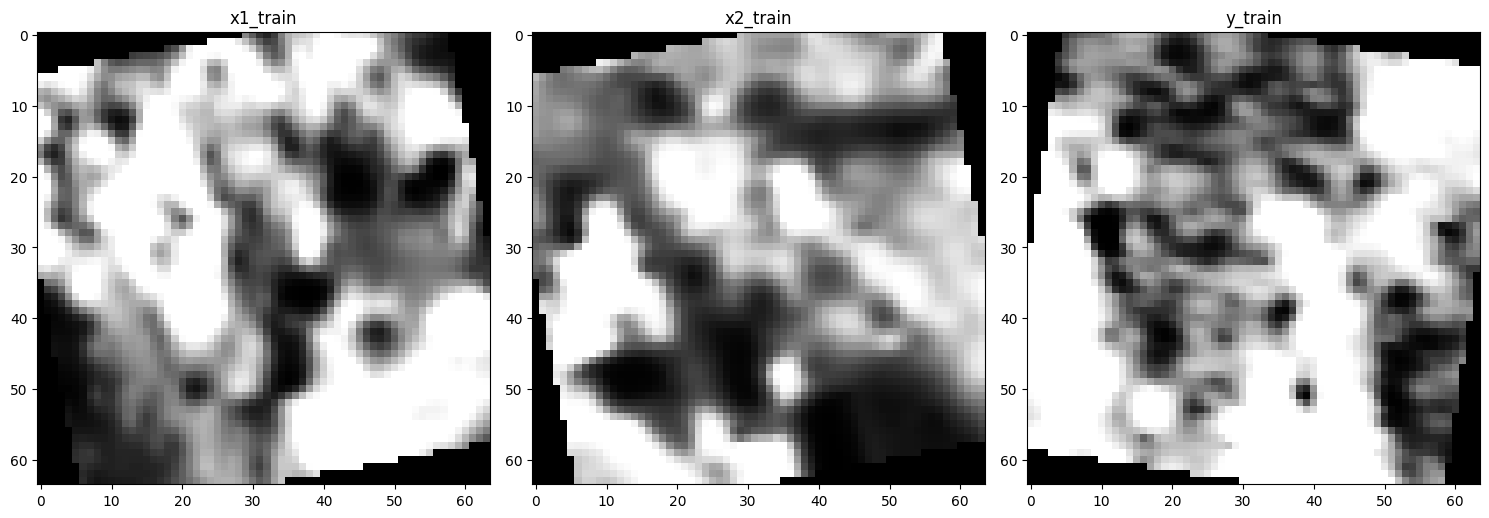

In [5]:
print(x_train.shape, x_test.shape)

# Visualize the images side by side

plt.figure(figsize=(15, 5))

j = 66

plt.subplot(1, 3, 1)
plt.imshow(x_train[j], cmap='gray')
plt.title('x1_train')

plt.subplot(1, 3, 2)
plt.imshow(x_train[j+1, :, :], cmap='gray')
plt.title('x2_train')

plt.subplot(1, 3, 3)
plt.imshow(x_train[j+2, :, :], cmap='gray')
plt.title('y_train')

plt.tight_layout()
plt.show()

Min: 0.0
Max: 0.9882353
Mean: 0.44932503
Standard Deviation: 0.3045543


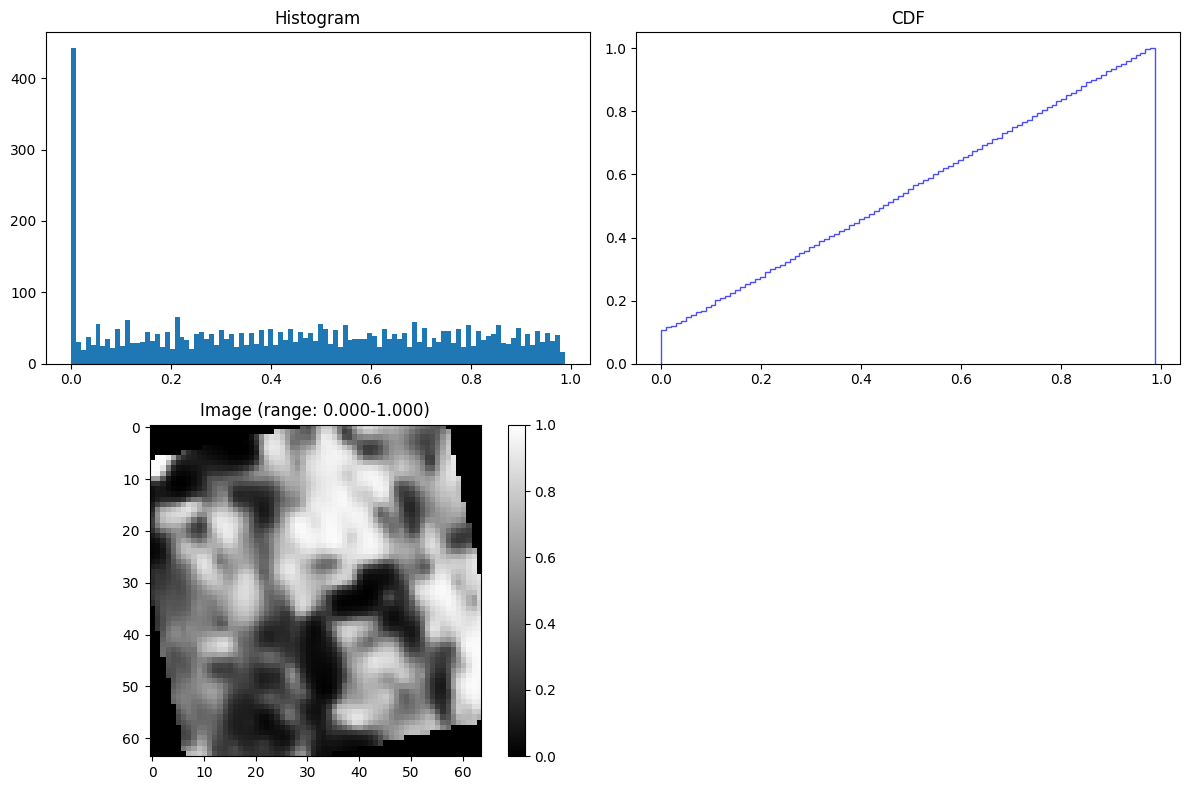

In [10]:
def visualize_image(img_data):
    # Load the image using raster.io
    """with rasterio.open(image_path, 'r') as src:
        img_data = src.read(1)"""
    
    # Print basic statistics
    print("Min:", np.nanmin(img_data))
    print("Max:", np.nanmax(img_data))
    print("Mean:", np.nanmean(img_data))
    print("Standard Deviation:", np.nanstd(img_data))
    
    valid_data = img_data[~np.isnan(img_data)]
    
    # Plot the histogram
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.hist(valid_data.ravel(), bins=100)
    plt.title("Histogram")
    
    # Plot the CDF
    plt.subplot(2, 2, 2)
    plt.hist(valid_data.ravel(), bins=100, cumulative=True, density=True, histtype='step', color='blue', alpha=0.7)
    plt.title("CDF")
    
    # Plot the image using mean±2 standard deviations as the display range
    plt.subplot(2, 2, 3)
    vmin = max(0, np.nanmean(img_data) - 2*np.nanstd(img_data))
    vmax = min(1, np.nanmean(img_data) + 2*np.nanstd(img_data))
    plt.imshow(img_data, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(f"Image (range: {vmin:.3f}-{vmax:.3f})")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

visualize_image(x_train[j])

## Training an autoencoder

In [27]:
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9
    return lr

def create_autoencoder(input_shape):
    input_img = Input(shape=input_shape)  # adapt this if using `channels_first` image data format

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


    # Define the optimizer with a custom learning rate
    optimizer = Adam(learning_rate=0.0005)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

    return autoencoder

def create_adjusted_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), loss='mean_squared_error')

    return autoencoder

#autoencoder = create_adjusted_autoencoder((64, 64, 1))

autoencoder = create_autoencoder((64, 64, 1))
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928 

In [28]:
# Reshaping the channel
x_train = x_train.reshape(-1, 64, 64, 1)

# EarlyStopping function
early_stopping = EarlyStopping(
    monitor='val_loss',   # Value to be monitored
    patience=5,           # Number of epochs with no improvement after which the training will be stopped
    mode='auto',          # 'auto', 'min' or 'max'. In 'auto', algorithm will detect the direction
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value result
)

# Train the autoencoder
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/50
43/43 [==============================] - 7s 25ms/step - loss: 0.0528 - val_loss: 0.0202
Epoch 2/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0170 - val_loss: 0.0141
Epoch 3/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0126 - val_loss: 0.0110
Epoch 4/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0102 - val_loss: 0.0090
Epoch 5/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 6/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 7/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 8/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 9/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 10/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 11/

### Visualize results

1/1 [==============================] - 0s 10ms/step


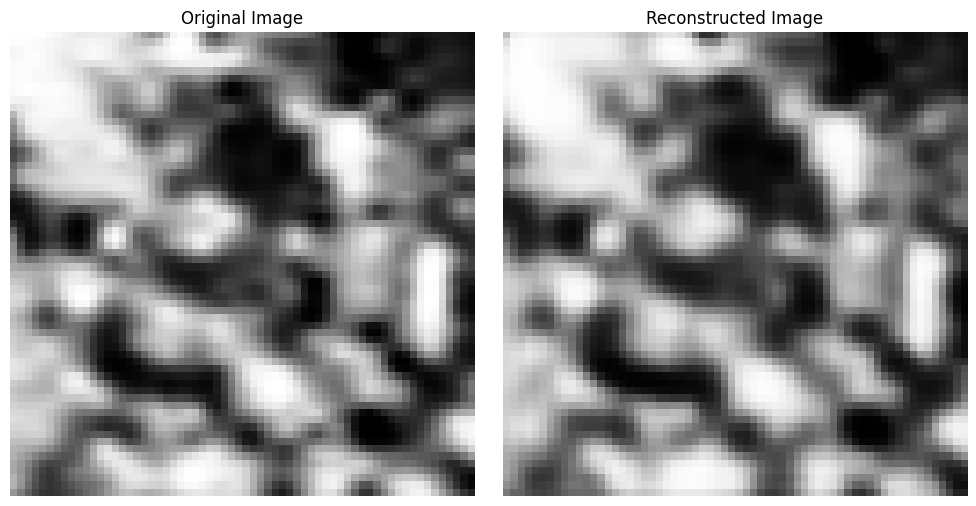

In [39]:
# Choose an image for visualization
index = 11
test_image = x_test[index]
test_image_reshaped = test_image.reshape(1, 64, 64, 1)  # reshape for prediction

# Make a prediction
predicted_image = autoencoder.predict(test_image_reshaped)

# Reshape predicted image for visualization
predicted_image = predicted_image.reshape(64, 64)

# Plot original vs reconstructed
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(test_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(predicted_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis("off")

plt.tight_layout()
plt.show()

## Evaluation

Lets evaluate using Mean squared error (MSE, i.e. reconstruction loss) and Structural similarity index (SSIM)

In [30]:
def compute_mse_ssim(autoencoder, test_images):
    """
    Compute the MSE and SSIM for the set of test images using the provided autoencoder.

    :param autoencoder: Trained autoencoder model
    :param test_images: List or numpy array of test images
    :return: Average MSE and average SSIM for the test set
    """

    # Get the autoencoder's predictions
    reconstructed_images = autoencoder.predict(test_images)

    # Initialize accumulators for MSE and SSIM
    mse_accumulator = 0.0
    ssim_accumulator = 0.0

    # Compute MSE and SSIM for each image
    for original, reconstructed in zip(test_images, reconstructed_images):
        # MSE
        mse_accumulator += K.mean(K.square(original - reconstructed))

        # Scale the images to be in the range [0,255] for SSIM computation
        original_for_ssim = (original * 255).astype(np.uint8)
        reconstructed_for_ssim = (reconstructed * 255).astype(np.uint8)

        # SSIM (used on 2D grayscale images; adapt as necessary for color images)
        ssim_value, _ = ssim(original_for_ssim.squeeze(), reconstructed_for_ssim.squeeze(), full=True)
        ssim_accumulator += ssim_value

    # Calculate average MSE and SSIM
    avg_mse = mse_accumulator / len(test_images)
    avg_ssim = ssim_accumulator / len(test_images)

    return avg_mse, avg_ssim

avg_mse, avg_ssim = compute_mse_ssim(autoencoder, x_test)
print(f"Average MSE: {avg_mse}, Average SSIM: {avg_ssim}")

10/10 [==============================] - 0s 2ms/step
Average MSE: 0.002289454685524106, Average SSIM: 0.9365273173131262


## Applications

In [ ]:
"""Latent space visualization"""

print(x_test.shape)

for layer in autoencoder.layers:
    print('Layer name:', layer.name)

#encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_1').output)

encoded_images = encoder_model.predict(x_test)

print(encoded_images.shape)

reshaped_data = encoded_images.reshape(encoded_images.shape[0], -1)

# Reduce dimensionality to 2D for visualization
encoded_2D = TSNE(n_components=2, perplexity=20).fit_transform(reshaped_data)
encoded_3D = TSNE(n_components=3, perplexity=20).fit_transform(reshaped_data)

plt.scatter(encoded_2D[:, 0], encoded_2D[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D TSNE of Encoded Images')
plt.show()


"""Dimensionality reduction"""

# Extract the encoder
#encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [ ]:
# 3D representation

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(encoded_3D[:, 0], encoded_3D[:, 1], encoded_3D[:, 2], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("3D t-SNE Visualization")

plt.show()

## Find an optimal number of computing units (Convolutional filters & layers)

In [ ]:
def create_autoencoder_looping(input_shape, num_layers, num_filters):
    input_img = Input(shape=input_shape)
    x = input_img
    
    # Encoder
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)
    
    return Model(input_img, decoded)

def create_adjusted_autoencoder_looping(input_shape, num_layers, num_filters):
    input_img = Input(shape=input_shape)
    x = input_img
    num_filters = initial_num_filters
    
    # Encoder
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        num_filters *= 2  # Double the number of filters for the next layer
    
    # Decoder
    # Start with half of the final number of filters from the encoder
    num_filters //= 2
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        num_filters //= 2  # Halve the number of filters for the next layer

    decoded = Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)
    
    return Model(input_img, decoded)

def create_autoencoder_symmetrical_looping(input_shape, num_layers, initial_num_filters):
    input_img = Input(shape=input_shape)
    x = input_img
    filters = []
    num_filters = initial_num_filters
    
    # Encoder
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        filters.append(num_filters)
        num_filters *= 2  # Double the number of filters for the next layer
    
    # Decoder
    for f in reversed(filters): # take the stored list of filters and apply it reversely (from largest to smallest) to achieve symmetry
        x = Conv2D(f, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)
    
    return Model(input_img, decoded)

results = []

x_train = x_train.reshape(-1, 64, 64, 1)

# Loop over different architectures to find the best one
for num_layers in [1, 2, 3, 4, 5]:  # list of layer counts to test
    for num_filters in [8, 16, 32, 64, 128]:  # list of filter counts counts to test
        model = create_autoencoder_symmetrical_looping(x_train.shape[1:], num_layers, num_filters)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), loss='mean_squared_error')
        
        model.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test))
        
        loss = model.evaluate(x_test, x_test)
        
        results.append({
            'num_layers': num_layers,
            'num_filters': num_filters,
            'loss': loss
        })

# Sort results by loss to find the best configuration
sorted_results = sorted(results, key=lambda x: x['loss'])
print(sorted_results[0])  # print the architecture with the lowest loss

Find the smallest model (as per layers, then convolutional filters) that exceeds some baseline, here MSI loss

In [ ]:
# Flatten the loops into a list of configurations
configs = [(layers, filters) for layers in [1, 2, 3, 4, 5] for filters in [8, 16, 32, 64, 128]]

# Sort configurations by complexity
configs.sort(key=lambda x: (x[0], x[1]))

min_acceptable_performance = 0.1  # 90% accuracy in terms of mean squared error
best_config = None

for num_layers, initial_num_filters in configs:
    model_minimum = create_autoencoder_symmetrical_looping(x_train.shape[1:], num_layers, initial_num_filters)
    model_minimum.compile(optimizer='adam', loss='mean_squared_error')
    model_minimum.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=1)
    
    # Evaluate the model
    predictions = model_minimum.predict(x_test)
    mse = mean_squared_error(x_test.flatten(), predictions.flatten())
    
    if mse <= min_acceptable_performance:
        best_config = (num_layers, initial_num_filters)
        break

print(f"The smallest configuration that exceeds the performance criteria is {best_config}")

In [ ]:
# Choose an image for visualization
index = 1 
test_image = x_test[index]
test_image_reshaped = test_image.reshape(1, 64, 64, 1)  # reshape for prediction

# Make a prediction
predictions = autoencoder.predict(test_image_reshaped)

# Reshape predicted image for visualization
predictions = predictions.reshape(64, 64)

print(x_test[0].shape, predictions[0].shape)

# Plot original vs reconstructed
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(x_test[0], cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(predictions[0], cmap='gray')
plt.title("Reconstructed Image")
plt.axis("off")

plt.tight_layout()
plt.show()

## Autoencoder with skip-connections and attention block

In [23]:
# A layer to scale the multimodal inputs
class ScalingLayer(Layer):
    def __init__(self, multipliers, **kwargs):
        super(ScalingLayer, self).__init__(**kwargs)
        self.multipliers = tf.constant(multipliers, dtype=tf.float32)

    def call(self, inputs):
        # Rescale each tensor based on its corresponding multiplier
        return [inputs[i] * self.multipliers[i] for i in range(len(inputs))]

    def get_config(self):
        config = super(ScalingLayer, self).get_config()
        config.update({'multipliers': self.multipliers.numpy().tolist()})
        return config

# Attention blocks

def attention_block(x, shortcut):
    g = Conv2D(filters=shortcut.shape[-1], kernel_size=1, strides=1, padding='same')(x)
    x = Conv2D(filters=shortcut.shape[-1], kernel_size=1, strides=1, padding='same')(shortcut)
    f = Activation('relu')(g + x)
    psi = Conv2D(filters=1, kernel_size=1, strides=1, padding='same')(f)
    rate = Activation('sigmoid')(psi)
    att_x = Multiply()([shortcut, rate])
    return att_x

def attention_block_skip(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x)
    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1])(g)
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, [1, 1], strides=[1, 1])(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = Multiply()([x, rate])
    return att_x

def build_autoencoder_multichannel_skip_attention_modular(resolution, modality, dropout=0.2, regularization=0, 
                                                  modality_multipliers=None, number_of_layers=3, filter_size_start=8):
    
    # List to hold all input layers
    input_imgs = [Input(shape=(resolution, resolution, 1)) for _ in range(modality)]
    skip_connections = [] 
    encoded_imgs = []
    
    if modality_multipliers is None:
        multipliers = [1 for _ in range(modality)]
    else:
        multipliers = modality_multipliers

    # Scaling
    scaling_layer = ScalingLayer(multipliers=multipliers)
    scaled_imgs = scaling_layer(input_imgs)

    # Encoder
    for idx, input_img in enumerate(scaled_imgs):
        x = input_img
        current_filter_size = filter_size_start
        for i in range(number_of_layers):
            x = Conv2D(current_filter_size, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
            x = Dropout(dropout)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            # Store the encoder output for skip connections
            skip_connections.append(x)
            
            x = MaxPooling2D((2, 2), padding='same')(x)
            current_filter_size *= 2  # Double the filter size for the next layer
        encoded_imgs.append(x)

    x = concatenate(encoded_imgs, axis=-1)

    # Decoder
    current_filter_size = filter_size_start * number_of_layers
    for i in range(number_of_layers):
        x = Conv2D(current_filter_size, (3, 3), padding='same', kernel_regularizer=l1(regularization))(x)
        x = Dropout(dropout)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = UpSampling2D((2, 2))(x)
        
        # Get the corresponding encoder output for skip connection
        skip = skip_connections[-(i+1)]
        
        # Apply the attention block to skip connection
        x = attention_block_skip(x, skip, current_filter_size)
        
        current_filter_size //= 2  # Halve the filter size for the next layer

    # Output layer
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder_multi_channel = Model(input_imgs, decoded)
    return autoencoder_multi_channel

In [24]:
# Usage
autoencoder_unet = build_autoencoder_multichannel_skip_attention_modular(256, 3, 0.15, 0, [0.8, 1, 0.15], 3, 8)
autoencoder_unet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), loss='mean_squared_error')

## Use pre-trained VGG models for the encoder

Option to load a pre-trained VGG model and use it for the encoder, while freezing it's weights (i.e. using it as-is). Note that VGG and most other models as well are RGB, so we need to create a 3 -> 1 band layer (which is also done here)

In [2]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import VGG16, VGG19

def build_vgg19_autoencoder(resolution):
    
    # Load VGG without its top layers, and with default input shape
    vgg19 = keras.applications.VGG19(include_top=False, weights='imagenet')
    
    # Create a new input layer for single channel input
    input_layer = keras.layers.Input(shape=(resolution, resolution, 1))
    
    # The new first layer won't have pretrained weights
    x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    
    x = Conv2D(3, (1, 1), activation='relu')(x)  # Convert 64 channels to 3 channels
    
    # Apply the VGG layers (skip the original input layer of VGG)
    for layer in vgg19.layers[1:]:
        x = layer(x)
    
    # New VGG model with modified input
    modified_vgg19 = keras.models.Model(inputs=input_layer, outputs=x)
    
    #Freeze VGG19 layers
    for layer in modified_vgg19.layers:
        layer.trainable = False
        
    #Summary of the pre-trained encoder model
    print(modified_vgg19.summary())
    
    input_img = Input(shape=(resolution, resolution, 1))
    encoded = modified_vgg19(input_img)
    
    # decoder to match the pre-trained encoder and upscale
    x = Conv2D(256, (3, 3), padding='same')(encoded)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Create the Autoencoder model
    autoencoder_vgg19 = Model(input_img, decoded)
    
    print(autoencoder_vgg19.summary())

    return autoencoder_vgg19

In [ ]:
def preprocess_grayscale_for_vgg(image):
    # Convert 1-channel grayscale to 3-channel grayscale
    image_rgb = tf.concat([image, image, image], axis=-1)
    return preprocess_input(image_rgb * 255.0)  # VGG's 'preprocess_input' function expects pixel values in [0, 255]

autoencoder_vgg19.compile(optimizer=tf.keras.optimizers.Adadelta(lr=0.003), loss='mean_squared_error')

## Variational autoencoder (Not completed, experimental)

Variational autoencoder can be used to generate more data, augmentate it or find some patterns. Like autoencoder, can capture the strucurality of the data and compress it

In [1]:
original_dim = 64 * 64
intermediate_dim = 256
latent_dim = 2
batch_size = 128
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
def create_vae(input_shape=(64, 64, 1)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    shape_before_flattening = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    
    # outputs: latent mean, and log variance
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    
    # Use reparameterization to push the sampling as input
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    
    # Initialize the encoder
    encoder = Model(input_img, [z_mean, z_log_var, z])
    
    # Decoder
    decoder_input = Input(K.int_shape(z)[1:])
    x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
    x = Reshape(shape_before_flattening[1:])(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Initialize the decoder
    decoder = Model(decoder_input, decoded)
    
    # Apply the decoder to the sample from the latent distribution
    z_decoded = decoder(z)
    
    # Initialize the VAE
    vae = Model(input_img, z_decoded)

    return vae

vae = create_vae()

# Compute VAE loss
xent_loss = 64 * 64 * binary_crossentropy(K.flatten(x_train[0]), K.flatten(z_decoded))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
beta = 1

reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(z_decoded))
reconstruction_loss *= 64 * 64

vae_loss_reconstruction = K.mean(reconstruction_loss + beta * kl_loss) # beta can be adjusted

#vae.add_loss(vae_loss)

vae.add_loss(vae_loss_reconstruction)
#vae.compile(optimizer='rmsprop')
vae.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002))

In [ ]:
# Train the model
vae.fit(x_train, None, epochs=1000, batch_size=batch_size, validation_data=(x_test, None))